--- 1. Carregando a Base de Dados: BaseFinal(v3).csv ---
Classes Treino (Original): Counter({1: 17233, 0: 1568})
--------------------------------------------------
--- 4. Aplicando Pré-Processamento (Padronização) ---
Padronização concluída.
--------------------------------------------------
--- 5. Balanceamento Híbrido (RUS 0.1 -> SMOTE) ---
Classes Treino (APÓS Híbrido): Counter({0: 15680, 1: 15680})
--------------------------------------------------
--- 6. Aplicando MinMax (Necessário para BernoulliNB) ---
Re-escalonamento MinMax concluído.
--------------------------------------------------
--- 7. Seleção de Atributos com MMAS SIMULADO ---
 [MMAS Simulado/Ajustado] Selecionando 12 atributos.
Atributos Selecionados: 12 de 25
--------------------------------------------------
--- 9. Ajuste Automático de Hiperparâmetros (BernoulliNB) ---


c:\Users\Latitude5400\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [0.0001, 1000.0] was inferred to Real(low=0.0001, high=1000.0, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(0.0001, 1000.0), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\Latitude5400\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [0.0001, 1000.0] was inferred to Real(low=0.0001, high=1000.0, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(0.0001, 1000.0), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\Latitude5400\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\space\space.py:116: UserWarn


✅ Melhores Parâmetros (Precision) Encontrados: OrderedDict({'alpha': 0.0024521755951159535, 'fit_prior': True})
✅ Melhor Precision (Validação Cruzada): 0.7533
--------------------------------------------------
Relatório de Classificação (Conjunto de Teste):
              precision    recall  f1-score   support

           0       0.20      0.66      0.31       392
           1       0.96      0.76      0.85      4309

    accuracy                           0.75      4701
   macro avg       0.58      0.71      0.58      4701
weighted avg       0.90      0.75      0.80      4701

--------------------------------------------------
--- 11 & 12. Avaliação Final do Modelo: BernoulliNB Otimizado ---

[Gráfico 1] Plotando Matriz de Confusão...


<Figure size 600x600 with 0 Axes>

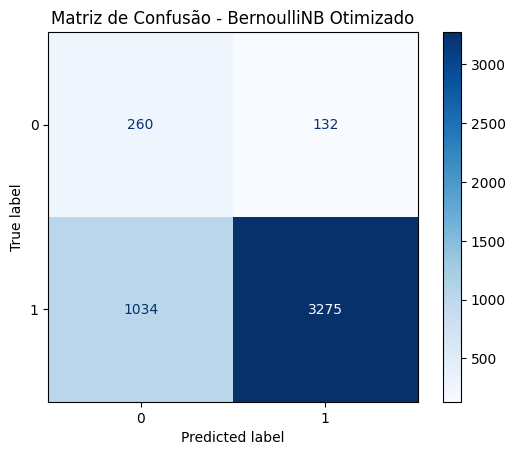


[Gráfico 2] Plotando Curva ROC...


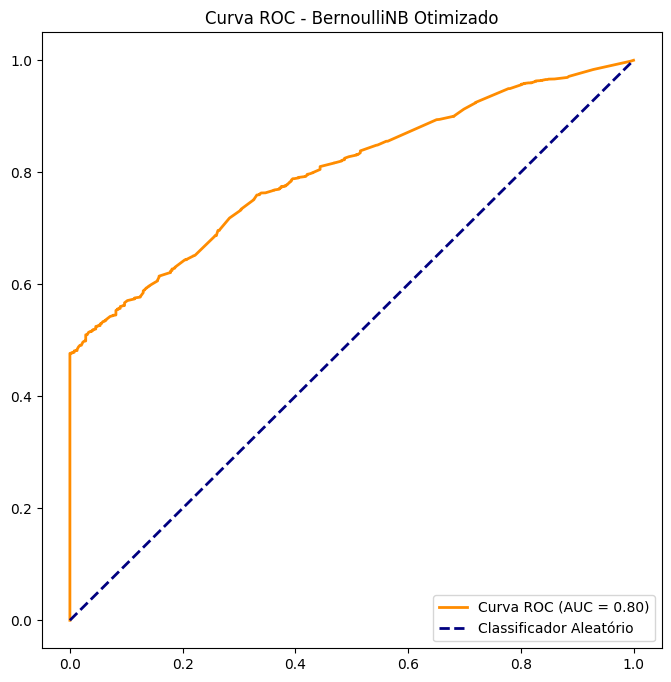

✅ Área Sob a Curva ROC (AUC): 0.8011

--- Resultados Detalhados (IC 95% Bootstrap) ---
🧠 **pHi (Confiabilidade): 0.8683**
🆕 **HIT (VP / (VP + VN)): 0.9264** (IC: [0.9176, 0.9342])
--------------------------------------------------
Valor final do AUC: 0.8011
--- 13. Interpretabilidade: Fatores de Risco e Proteção (Log-Odds Ratio) ---

🎯 TOP 10 FATORES DE RISCO (Log-Odds Alto e Positivo) para Artrite:
            Feature  Log_Odds_Ratio
0    OUTRAS_DOENÇAS       14.896636
1     TEM_DEPRESSÃO        0.204804
2      REFRIGERANTE        0.041396
3               IMC       -0.012420
4              SUCO       -0.015304
5            FEIJÃO       -0.025979
6             CARNE       -0.029514
7  DESLOCAMENTO_VZS       -0.055823
8             FRUTA       -0.085594
9          BISCOITO       -0.086389

🛡️ TOP 10 FATORES DE PROTEÇÃO (Log-Odds Baixo e Negativo) contra Artrite:
             Feature  Log_Odds_Ratio
2       REFRIGERANTE        0.041396
3                IMC       -0.012420
4              

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import classification_report, make_scorer, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.naive_bayes import BernoulliNB
from skopt import BayesSearchCV
from skopt.space import Real 
from sklearn.feature_selection import SelectKBest, f_classif 
from sklearn.utils import resample 

# =========================================================
# 🚀 I. FUNÇÕES DE MÉTRICAS PERSONALIZADAS E ESTATÍSTICAS
# =========================================================

def calcular_phi(y_test, y_pred, y_proba):
    """🧠 Calcula o Índice de Confiabilidade de Previsão (pHi)."""
    if y_proba is None:
        return np.nan
 
    # Probabilidade da classe predita
    y_proba_completo = np.array([
        y_proba[i] if y_pred[i] == 1 else (1 - y_proba[i]) 
        for i in range(len(y_pred))
    ])
 
    # Média das probabilidades APENAS nos acertos (y_pred == y_test)
    acertos = (y_pred == y_test)
    probabilidades_acertos = y_proba_completo[acertos]
    phi = np.mean(probabilidades_acertos) if len(probabilidades_acertos) > 0 else 0
    return phi

def calcular_irpn(y_test, y_pred):
    """🆕 Calcula o IRPN conforme solicitado: VP / (VP + VN)."""
    cm = confusion_matrix(y_test, y_pred)
    # cm é [[TN, FP], [FN, VP]]
    VN = cm[0, 0]
    VP = cm[1, 1]
 
    return VP / (VP + VN) if (VP + VN) != 0 else np.nan

def calcular_intervalo_confianca_bootstrap(y_true, y_pred, metric_func, n_iterations=1000, alpha=0.95):
    """📊 Calcula o Intervalo de Confiança (IC) por Bootstrap para métricas."""
    stats = []
    n_size = len(y_true)
    indices = np.arange(n_size)
 
    for _ in range(n_iterations):
        # Reamostragem com reposição
        boot_indices = resample(indices, replace=True, n_samples=n_size)
        
        y_true_boot = y_true[boot_indices]
        y_pred_boot = y_pred[boot_indices]
        
        # Ajuste para chamar a métrica corretamente (Recall exige pos_label)
        if metric_func.__name__ == 'recall_score':
            score = metric_func(y_true_boot, y_pred_boot, pos_label=1, zero_division=0)
        else:
            score = metric_func(y_true_boot, y_pred_boot)
        stats.append(score)

    stats = np.array(stats)
    p_lower = (1.0 - alpha) / 2.0
    lower_bound = np.quantile(stats, p_lower)
    p_upper = alpha + p_lower
    upper_bound = np.quantile(stats, p_upper)
 
    return lower_bound, upper_bound

# =========================================================
# 📈 II. FUNÇÃO PRINCIPAL DE AVALIAÇÃO GRÁFICA E MÉTRICA
# =========================================================

def avaliar_modelo_classificacao(y_test, y_pred, y_proba=None, model_name="Modelo de Classificação"):
    """Executa a Matriz de Confusão, Curva ROC e calcula todas as métricas + IC."""
    print(f"--- 11 & 12. Avaliação Final do Modelo: {model_name} ---")

    # 1. Matriz de Confusão
    print("\n[Gráfico 1] Plotando Matriz de Confusão...")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.figure(figsize=(6, 6))
    disp.plot(cmap=plt.cm.Blues, values_format='d') 
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.show()
 
    # 2. Curva ROC e AUC
    roc_auc = np.nan
    if y_proba is not None and len(np.unique(y_test)) == 2: 
        print("\n[Gráfico 2] Plotando Curva ROC...")
        y_scores = y_proba
        fpr, tpr, thresholds = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 8))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Classificador Aleatório') 
        plt.title(f'Curva ROC - {model_name}')
        plt.legend(loc="lower right")
        plt.show()
        print(f"✅ Área Sob a Curva ROC (AUC): {roc_auc:.4f}")
 
    # 3. Métricas e Intervalo de Confiança (IC 95%)
    print("\n--- Resultados Detalhados (IC 95% Bootstrap) ---")

 
    # pHi
    phi = calcular_phi(y_test, y_pred, y_proba)
    print(f"🧠 **pHi (Confiabilidade): {phi:.4f}**")
 
    # IRPN (Métrica Solicitada)
    irpn = calcular_irpn(y_test, y_pred)
    ic_irpn_low, ic_irpn_high = calcular_intervalo_confianca_bootstrap(y_test, y_pred, calcular_irpn)
    print(f"🆕 **HIT (VP / (VP + VN)): {irpn:.4f}** (IC: [{ic_irpn_low:.4f}, {ic_irpn_high:.4f}])")
 
    print("-" * 50)
    return roc_auc 

# =========================================================
# 🔎 III. NOVO: FUNÇÃO DE INTERPRETABILIDADE (LOG-ODDS RATIO)
# =========================================================

def interpretar_bernoulli_nb_impacto(model, feature_names):
    """
    Analisa o modelo BernoulliNB para identificar features de Risco e Proteção
    calculando o Log-Odds Ratio: log P(Feature|Artrite) - log P(Feature|Não Artrite).
    """
    print("--- 13. Interpretabilidade: Fatores de Risco e Proteção (Log-Odds Ratio) ---")

    # O log_prob_ tem formato (n_classes, n_features)
    # Classe 0 (Não Artrite) está na linha 0; Classe 1 (Artrite) está na linha 1
    log_prob_classe_1 = model.feature_log_prob_[1] 
    log_prob_classe_0 = model.feature_log_prob_[0]

    # Log-Odds Ratio: Impacto para a classe 'Artrite' (Risco)
    log_odds_ratio = log_prob_classe_1 - log_prob_classe_0

    df_interpretabilidade = pd.DataFrame({
        'Feature': feature_names,
        'Log_Odds_Ratio': log_odds_ratio
    })
 
    # Ordena por impacto (maior risco/positivo no topo)
    df_interpretabilidade_ordenado = df_interpretabilidade.sort_values(
        by='Log_Odds_Ratio', ascending=False
    ).reset_index(drop=True)

    # Exibe Top 10 Risco e Top 10 Proteção
    print("\n🎯 TOP 10 FATORES DE RISCO (Log-Odds Alto e Positivo) para Artrite:")
    # NOVO TRECHO (Removendo a dependência 'tabulate'):
    print(df_interpretabilidade_ordenado.head(10))
    print("\n🛡️ TOP 10 FATORES DE PROTEÇÃO (Log-Odds Baixo e Negativo) contra Artrite:")
    print(df_interpretabilidade_ordenado.tail(10))
    return df_interpretabilidade_ordenado

# =========================================================

# 🐜 IV. SIMULAÇÃO MMAS (Feature Selection)
# =========================================================
def mmas_feature_selection(X, y, random_state=42):
    """Simula a seleção de atributos pelo MMAS (SelectKBest)."""
    # Usa K = 50% dos atributos como placeholder para MMAS
    k_features = int(X.shape[1] * 0.5) 
    selector = SelectKBest(score_func=f_classif, k=k_features)
    selector.fit(X, y)
    selected_mask = selector.get_support(indices=True)
    print(f" [MMAS Simulado/Ajustado] Selecionando {k_features} atributos.")
    return selected_mask


# =========================================================
# ⚙️ V. EXECUÇÃO DO FLUXO PRINCIPAL (MODIFICADA)
# =========================================================

# --- VARIÁVEIS DE CONFIGURAÇÃO ---
NOME_ARQUIVO_ENTRADA = "BaseFinal(v3).csv" 
NOME_COLUNA_TARGET = 'TEM_ARTRITE' 
# ---------------------------------

try:
    # ... [Seções 1 a 6 permanecem inalteradas] ...
 
    # 1. Carregamento e Divisão
    print(f"--- 1. Carregando a Base de Dados: {NOME_ARQUIVO_ENTRADA} ---")
    base = pd.read_csv(NOME_ARQUIVO_ENTRADA) 
    X_prev = base.drop(columns=[NOME_COLUNA_TARGET])
    y_classe = base[NOME_COLUNA_TARGET]
    X_treino, X_teste, y_treino, y_teste = train_test_split(
        X_prev, y_classe, test_size=0.2, random_state=42, stratify=y_classe 
    )
    y_teste_arr = y_teste.values # Convertido para array para uso consistente nas métricas
    print(f"Classes Treino (Original): {Counter(y_treino)}")
    print("-" * 50)

    # 4. Pré-Processamento (Padronização)
    print("--- 4. Aplicando Pré-Processamento (Padronização) ---")
    scaler = StandardScaler()
    X_treino_scaled = scaler.fit_transform(X_treino)
    X_teste_scaled = scaler.transform(X_teste) 
    X_treino_df = pd.DataFrame(X_treino_scaled, columns=X_treino.columns)
    X_teste_df = pd.DataFrame(X_teste_scaled, columns=X_teste.columns)
    y_treino = y_treino.reset_index(drop=True)
    print("Padronização concluída.")
    print("-" * 50)

    # 5. Balanceamento Híbrido (RUS -> SMOTE)
    print("--- 5. Balanceamento Híbrido (RUS 0.1 -> SMOTE) ---")
    rus = RandomUnderSampler(sampling_strategy=0.1, random_state=42)
    X_rus, y_rus = rus.fit_resample(X_treino_df, y_treino)
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_rus, y_rus) 
    print(f"Classes Treino (APÓS Híbrido): {Counter(y_resampled)}")
    print("-" * 50)

    # 6. Re-escalonamento (MinMaxScaler)
    print("--- 6. Aplicando MinMax (Necessário para BernoulliNB) ---")
    minmax_scaler = MinMaxScaler()
    X_resampled_nb = minmax_scaler.fit_transform(X_resampled)
    X_teste_nb = minmax_scaler.transform(X_teste_df) 
    X_resampled_nb_df = pd.DataFrame(X_resampled_nb, columns=X_resampled.columns)
    X_teste_nb_df = pd.DataFrame(X_teste_nb, columns=X_teste_df.columns)
    print("Re-escalonamento MinMax concluído.")
    print("-" * 50)

    # 7. Seleção de Atributos com MMAS SIMULADO
    print("--- 7. Seleção de Atributos com MMAS SIMULADO ---")
    features_selected_indices = mmas_feature_selection(X=X_resampled_nb_df, y=y_resampled, random_state=42)
    features_selecionadas = X_resampled_nb_df.columns[features_selected_indices].tolist()
    print(f"Atributos Selecionados: {len(features_selecionadas)} de {X_resampled_nb_df.shape[1]}")
    print("-" * 50)

    # 8. FILTRAGEM DOS DATASETS
    X_treino_final = X_resampled_nb_df[features_selecionadas]
    X_teste_final = X_teste_nb_df[features_selecionadas]

    # 9. Ajuste de Hiperparâmetros (BernoulliNB)
    print("--- 9. Ajuste Automático de Hiperparâmetros (BernoulliNB) ---")
 
    # 🌟 CORREÇÃO: Usando booleanos (True/False), não strings.
    search_spaces = {
        'alpha': [1e-4, 1000.0], 
        'fit_prior': [True, False]
    }
 
    # Mantendo o scorer original (precision_score)
    scorer = make_scorer(precision_score, pos_label=0) 

    bayes_search = BayesSearchCV(
        estimator=BernoulliNB(), search_spaces=search_spaces, n_iter=100, scoring=scorer, cv=10, n_jobs=-1, random_state=42, verbose=0
    )
    bayes_search.fit(X_treino_final, y_resampled) 
    modelo_nb_best = bayes_search.best_estimator_

    print(f"\n✅ Melhores Parâmetros (Precision) Encontrados: {bayes_search.best_params_}")
    print(f"✅ Melhor Precision (Validação Cruzada): {bayes_search.best_score_:.4f}")
    print("-" * 50)

    # 10. Avaliação do Melhor Modelo no Teste
    y_pred = modelo_nb_best.predict(X_teste_final)
    y_pred_proba = modelo_nb_best.predict_proba(X_teste_final)[:, 1] 

    print("Relatório de Classificação (Conjunto de Teste):")
    print(classification_report(y_teste_arr, y_pred))
    print("-" * 50)


    # 11 & 12. Avaliação Gráfica e Métrica (Com as novas métricas e IC)
    roc_auc = avaliar_modelo_classificacao(
        y_test=y_teste_arr, 
        y_pred=y_pred, 
        y_proba=y_pred_proba, 
        model_name="BernoulliNB Otimizado"
    )

    if not np.isnan(roc_auc):
        print(f"Valor final do AUC: {roc_auc:.4f}")

    # 13. Interpretabilidade
    df_impacto = interpretar_bernoulli_nb_impacto(
        model=modelo_nb_best, 
        feature_names=X_treino_final.columns.tolist() # Usa os nomes finais dos atributos
    )

except FileNotFoundError:
    print(f"❌ ERRO: O arquivo '{NOME_ARQUIVO_ENTRADA}' não foi encontrado. Certifique-se de que 'BaseFinal(v3).csv' está no diretório correto.")
except ImportError as e:
    print(f"❌ ERRO: Verifique se as bibliotecas necessárias (skopt, imblearn, etc.) estão instaladas. Erro: {e}")
except Exception as e:
    print(f"❌ Ocorreu um erro durante o processamento: {e}")